In [1]:
import math
import random
import pickle
import datetime
import numpy as np
import networkx as nx
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from collections import defaultdict
from scipy.interpolate import griddata

In [2]:
class OOMFormatter(matplotlib.ticker.ScalarFormatter):
    def __init__(self, order=0, fformat="%1.0f", offset=True, mathText=True):
        self.oom = order
        self.fformat = fformat
        matplotlib.ticker.ScalarFormatter.__init__(self,useOffset=offset,useMathText=mathText)
    def _set_orderOfMagnitude(self, nothing):
        self.orderOfMagnitude = self.oom
    def _set_format(self, vmin, vmax):
        self.format = self.fformat
        if self._useMathText:
            self.format = '$%s$' % matplotlib.ticker._mathdefault(self.format)

In [3]:
Data_Root = '/l/nx/data/haopeng/Diffusion/RealNet/per_step_data/'
net_name = 'twitter'

In [4]:
with open('/l/nx/data/haopeng/Diffusion/RealNet/networks/partition_%s.pickle'%net_name, 'rb') as file:
    part = pickle.load(file)

In [5]:
num_nodes = len(part)
num_runs = 100
thsh = 0.3
f = 0.01

In [8]:
num_nodes

81306

In [9]:
rhos = np.arange(0, 0.51, 0.01)
ps = np.arange(0, 1.02, 0.02)

In [5]:
sweeping_results = defaultdict(dict)

In [48]:
# run on hpc (see `twitter_hpc.py`)

In [7]:
# for i in range(51):
#     p = ps[i]
#     with open(Data_Root+'fix_thsh/phase_simu_%s_thsh_%s_f_%s_%s.pickle'%(net_name, thsh, f, i), 'rb') as file:
#         tem = pickle.load(file)
#         for rho, li in tem.items():
#             sweeping_results[rho][p] = li

In [8]:
# with open(Data_Root+'phase_simu_%s_thsh_%s_f_%s.pickle'%(net_name, thsh, f), 'wb') as file:
#     pickle.dump(dict(sweeping_results), file)

In [10]:
with open(Data_Root+'phase_simu_%s_thsh_%s_f_%s.pickle'%(net_name, thsh, f), 'rb') as file:
    sweeping_results = pickle.load(file)

In [11]:
def get_time_to_target(li, target):
    if target == num_nodes:
        target = num_nodes * 0.99
    li = np.array(li)
    li = np.cumsum(li)
    for i, tot in enumerate(li):
        if tot >= target:
            return i+1
    else:
        return 'impossible'

In [12]:
x_range = np.arange(0, 1.001, 0.001)
y_range = np.arange(0, 0.501, 0.001)
X, Y = np.meshgrid(x_range, y_range)

### Reach a target cascade size (phase diagram)

In [54]:
target_size = 0.20
target_size = 0.35
target_size = 0.50

In [55]:
points = []
rates_fix_size = []
max_rate = []

for rho in rhos:
    if rho < target_size:
        tem_max = 0
        max_u = 0
        for u in ps:
            rates = []
            for size, step, activation_per_step in sweeping_results[rho][u]:
                time_ss = get_time_to_target(activation_per_step, int(target_size * num_nodes))
                if time_ss != 'impossible':
                    rates.append((target_size-rho)/time_ss)
            # if len(rates) > 0:
            if len(rates) == num_runs:
                avg_rate = np.mean(rates)
                rates_fix_size.append(avg_rate)
                if avg_rate > tem_max:
                    max_u = u
                    tem_max = avg_rate
                points.append([u, rho])
        if tem_max > 0:
            max_rate.append([max_u, rho])
max_rate = np.array(max_rate)
Z_rate = griddata(points, rates_fix_size, (X, Y), method = 'cubic')

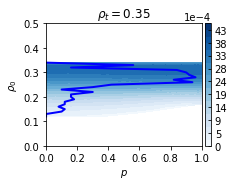

In [48]:
fig, ax = plt.subplots(figsize = (3, 2.25))
levels = np.linspace(0.0, 45e-4, 20)
ct = ax.contourf(X, Y, Z_rate, cmap = 'Blues', levels=levels)#, extend='min'
cb = fig.colorbar(ct, ax=ax, fraction=0.05, pad=0.02, format=OOMFormatter(-4, mathText=False))
cb.ax.tick_params(axis='y', direction='in')
ax.plot(max_rate[:, 0], max_rate[:, 1], linewidth = 2, color='b')
ax.set_xlabel(r'$p$')
ax.set_ylabel(r'$\rho_0$')
ax.set_xlim(0, 1)
ax.set_ylim(0, 0.5)
ax.set_title(r'$\rho_t = %.2f$'%target_size)
plt.show()
fig.savefig('Twitter_phase_target_%.2f.pdf'%target_size, bbox_inches='tight', pad_inches=0.02)

### Optimal modularity vs. Target size for different seed sizes

In [32]:
rho0s = [0.1, 0.15, 0.2, 0.25, 0.3]
rho0_dict = defaultdict(list)

for rho in rho0s:
    targets = np.arange(rho+0.05, 1, 0.05)
    targets = np.append(targets, 0.99)
    for target_size in targets:
        max_avg, max_u = 0, -1
        for u in ps:
            rates = []
            sizes = []
            for size, step, activation_per_step in sweeping_results[rho][u]:
                sizes.append(size/num_nodes)
                time_ss = get_time_to_target(activation_per_step, int(target_size * num_nodes))
                if time_ss != 'impossible':
                    rates.append((target_size-rho)/time_ss)
            # if the avg final size is at least the target size, then we count it as possible to reach the target.
            if np.mean(sizes) >= target_size:
                # under this condition, rates is impossible to be an empty list.
                avg_rate = np.mean(rates)
                if avg_rate > max_avg:
                    max_avg = avg_rate
                    max_u = u
        if max_u != -1:
            rho0_dict[rho].append([target_size, max_u])
    rho0_dict[rho] = np.array(rho0_dict[rho])

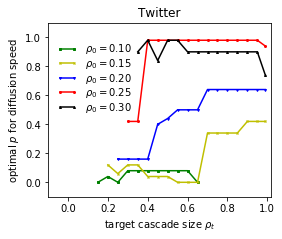

In [44]:
fig, ax = plt.subplots(figsize = (4, 3.2))

markers = ['-gs', '-yx', '-bv', '-ro', '-k^']
# markers = ['-s', '-x', '-v', '-o', '-^']
# cols = ['#FFB2B2', '#FF7F7F', '#FF4C4C', '#FF1919', '#990000']

for rho, mk in zip(rho0s, markers):
    target_max_u = rho0_dict[rho]
    ax.plot(target_max_u[:, 0], target_max_u[:, 1], mk, markersize = 2, linewidth = 1.5, label=r'$\rho_0 = %.2f$'%rho)
legend = ax.legend(loc=[0.02, 0.45], numpoints=2, labelspacing = 0.06, shadow=False, frameon = False)
ax.set_xlabel(r'target cascade size $\rho_t$')
ax.set_ylabel(r'optimal $p$ for diffusion speed')
# ax.tick_params(axis='y', labelcolor = col1, direction='out')
ax.set_xlim([-0.1, 1.02])
ax.set_ylim([-0.1, 1.1])
ax.set_title('Twitter')

plt.show()
fig.savefig('Twitter_opt_mu_vs_target.pdf', bbox_inches='tight', pad_inches=0.02)